In [1]:
from glom import glom, flatten
import pandas as pd
import json

import torch
import transformers

from datasets import load_dataset
import numpy as np

import matplotlib.pyplot as plt

from project import CreditDefault, PII, SkinCancer, set_seed

set_seed(1234)

## Credit-card default

In [2]:
credit = CreditDefault()
credit.prepare_dataset("cuda")

In [3]:
optimizers = {
    "adamw": (torch.optim.AdamW, {"lr": 1e-4}),
    "rmsprop": (torch.optim.RMSprop, {"lr": 2e-5}),
    "adagrad": (torch.optim.Adagrad, {"lr": 1e-5}),
}

schedulers = {
    "linear": (torch.optim.lr_scheduler.LinearLR, {"start_factor": 1/3, "end_factor": 1/1000, "total_iters": 5}),
    "cosine": (torch.optim.lr_scheduler.CosineAnnealingLR, {"T_max": 5, "eta_min": 0}),
    "polynomial": (torch.optim.lr_scheduler.PolynomialLR, {"total_iters": 5, "power": 2})
}

In [4]:
df = credit.train(
    result_pickle = "data/credit.pkl", 
    optimizers = optimizers,
    schedulers = schedulers,
    epochs = 5,
    batch_size = 2000,
    device = "cuda",
    loss_func = torch.nn.BCELoss,
    shuffle = True
    )

-------------------------------------
|linear, adamw|
Epoch 1
	batch 1 | loss: 22.371257781982422 | accuracy: 0.7735
	batch 2 | loss: 22.782608032226562 | accuracy: 0.7705
	batch 3 | loss: 23.856191635131836 | accuracy: 0.76
	batch 4 | loss: 23.1212100982666 | accuracy: 0.768
	batch 5 | loss: 22.699460983276367 | accuracy: 0.7725
	batch 6 | loss: 22.41942024230957 | accuracy: 0.775
	batch 7 | loss: 23.02280616760254 | accuracy: 0.7695
	batch 8 | loss: 22.086048126220703 | accuracy: 0.778
	batch 9 | loss: 21.735965728759766 | accuracy: 0.782
	batch 10 | loss: 20.59322166442871 | accuracy: 0.7925
	batch 11 | loss: 22.500141143798828 | accuracy: 0.775
	batch 12 | loss: 21.604469299316406 | accuracy: 0.7835
	batch 1 | loss: 21.282011032104492 | accuracy: 0.787
	batch 2 | loss: 22.470855712890625 | accuracy: 0.775
	batch 3 | loss: 21.82102394104004 | accuracy: 0.7815
	Average accuracy 0.7811666666666667
Epoch 2
	batch 1 | loss: 22.782136917114258 | accuracy: 0.772
	batch 2 | loss: 22.760128

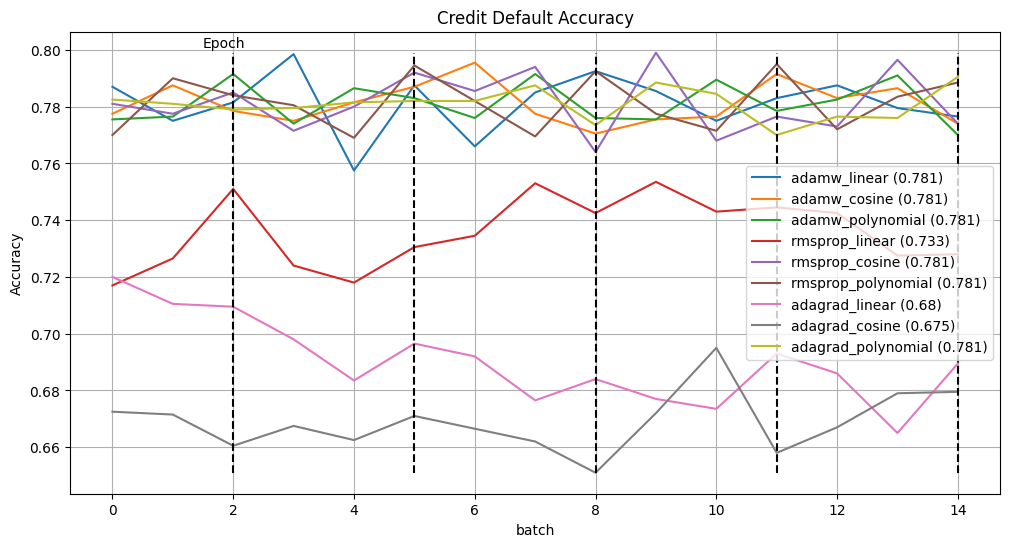

In [5]:
df = pd.read_pickle("data/credit.pkl")

plt.figure(figsize = (12,6))

_min = 1
_max = 0

for optim in df.index:
    for sched in df.columns:
        tpr,fpr, _ = dict(df.at[optim, sched])["roc_auc"]
        
        acc = np.array(df.at[optim, sched]["test_accuracy"]).flatten()
        if min(acc) < _min:
            _min = min(acc)
            
        if max(acc) > _max:
            _max = max(acc)
        
        plt.plot(acc, label = f"{optim}_{sched} ({round(df.at[optim, sched]['accuracy'],3)})")

plt.vlines(
    [3*(i)+2 for i in range(len(df.at[optim, sched]["test_accuracy"]))], 
    linestyles="--",
    color = "k", 
    ymin = _min, 
    ymax = _max
)
plt.text(1.5, _max+0.002, "Epoch")
    
        
plt.xlabel("batch")
plt.ylabel("Accuracy")
plt.title("Credit Default Accuracy")
plt.legend()
plt.grid()
plt.savefig("data/credit.png")
plt.show()

## PII

In [2]:
model_path = "distilbert/distilroberta-base"

pii = PII()
pii.load_tokenizer(model_path)
pii.prepare_dataset()

In [3]:
optimizers = {
    "adamw": (torch.optim.AdamW, {"lr": 1e-4}),
    "rmsprop": (torch.optim.RMSprop, {"lr": 3e-5, "momentum": 0}),
    "adagrad": (torch.optim.Adagrad, {"lr": 1e-4}),
}

schedulers = {
    "linear": {"num_warmup_steps": 0},
    "cosine": {"num_warmup_steps": 0},
    "polynomial": {"num_warmup_steps": 0, "power": 2}
}

In [4]:
df = pii.train(
    output_dir = "pii/",
    optimizers = optimizers,
    schedulers = schedulers,
    tokenizer_path = model_path,
    model_path = model_path,
    strategy = "epoch",
    epochs = 5,
    batch_size = 150,
    result_pickle = "data/pii.pkl",
    device = "cuda"
)

----------------------------
Optimizer: adamw | Scheduler: linear


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.06826945394277573, 'eval_precision': 0.911398332865037, 'eval_recall': 0.919059312429165, 'eval_f1': 0.9152127909710792, 'eval_accuracy': 0.9797490104630112, 'eval_runtime': 4.0226, 'eval_samples_per_second': 807.942, 'eval_steps_per_second': 5.469, 'epoch': 1.0}
{'eval_loss': 0.04877571761608124, 'eval_precision': 0.9382138176371466, 'eval_recall': 0.9465432565168115, 'eval_f1': 0.9423601316408087, 'eval_accuracy': 0.9860390905464699, 'eval_runtime': 3.923, 'eval_samples_per_second': 828.438, 'eval_steps_per_second': 5.608, 'epoch': 2.0}
{'eval_loss': 0.04975229501724243, 'eval_precision': 0.9438170525127046, 'eval_recall': 0.9472043823196071, 'eval_f1': 0.9455076836051663, 'eval_accuracy': 0.9864379736737136, 'eval_runtime': 3.9776, 'eval_samples_per_second': 817.08, 'eval_steps_per_second': 5.531, 'epoch': 3.0}
{'eval_loss': 0.048605822026729584, 'eval_precision': 0.9431796977047957, 'eval_recall': 0.9547601057801285, 'eval_f1': 0.9489345724209144, 'eval_accuracy': 0

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.06580626219511032, 'eval_precision': 0.9207494145199063, 'eval_recall': 0.9283150736683038, 'eval_f1': 0.9245167662136106, 'eval_accuracy': 0.9815593261943482, 'eval_runtime': 3.9037, 'eval_samples_per_second': 832.549, 'eval_steps_per_second': 5.636, 'epoch': 1.0}
{'eval_loss': 0.05650240555405617, 'eval_precision': 0.9271622253389434, 'eval_recall': 0.9365319229316207, 'eval_f1': 0.9318235211201429, 'eval_accuracy': 0.9839372832990703, 'eval_runtime': 3.8975, 'eval_samples_per_second': 833.877, 'eval_steps_per_second': 5.645, 'epoch': 2.0}
{'eval_loss': 0.0507744699716568, 'eval_precision': 0.9406358435712276, 'eval_recall': 0.9472988288628637, 'eval_f1': 0.9439555785610089, 'eval_accuracy': 0.9865300236261545, 'eval_runtime': 3.9005, 'eval_samples_per_second': 833.219, 'eval_steps_per_second': 5.64, 'epoch': 3.0}
{'eval_loss': 0.04816417023539543, 'eval_precision': 0.9478375082090252, 'eval_recall': 0.9541934265205894, 'eval_f1': 0.9510048477432109, 'eval_accuracy': 

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.06571752578020096, 'eval_precision': 0.9192289609779032, 'eval_recall': 0.9233094068757084, 'eval_f1': 0.9212646656928805, 'eval_accuracy': 0.981329201313246, 'eval_runtime': 4.0357, 'eval_samples_per_second': 805.311, 'eval_steps_per_second': 5.451, 'epoch': 1.0}
{'eval_loss': 0.05163491144776344, 'eval_precision': 0.9348457860691853, 'eval_recall': 0.9418209293539856, 'eval_f1': 0.9383203952011291, 'eval_accuracy': 0.9853640575619036, 'eval_runtime': 4.0156, 'eval_samples_per_second': 809.349, 'eval_steps_per_second': 5.479, 'epoch': 2.0}
{'eval_loss': 0.049327608197927475, 'eval_precision': 0.9395583832335329, 'eval_recall': 0.9484321873819418, 'eval_f1': 0.9439744312840759, 'eval_accuracy': 0.9862998987450523, 'eval_runtime': 4.0277, 'eval_samples_per_second': 806.921, 'eval_steps_per_second': 5.462, 'epoch': 3.0}
{'eval_loss': 0.048895109444856644, 'eval_precision': 0.9426751592356688, 'eval_recall': 0.9505100113335851, 'eval_f1': 0.9465763732129421, 'eval_accuracy

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.08515273034572601, 'eval_precision': 0.8911533117183882, 'eval_recall': 0.9085757461276918, 'eval_f1': 0.8997801992236824, 'eval_accuracy': 0.97638918719892, 'eval_runtime': 4.4374, 'eval_samples_per_second': 732.414, 'eval_steps_per_second': 4.958, 'epoch': 1.0}
{'eval_loss': 0.06193161383271217, 'eval_precision': 0.922020918939111, 'eval_recall': 0.9324707215715905, 'eval_f1': 0.9272163786626597, 'eval_accuracy': 0.982188334202694, 'eval_runtime': 3.9466, 'eval_samples_per_second': 823.493, 'eval_steps_per_second': 5.574, 'epoch': 2.0}
{'eval_loss': 0.0554983951151371, 'eval_precision': 0.9287911268524559, 'eval_recall': 0.94115980355119, 'eval_f1': 0.9349345592719426, 'eval_accuracy': 0.9843054831088337, 'eval_runtime': 3.9556, 'eval_samples_per_second': 821.622, 'eval_steps_per_second': 5.562, 'epoch': 3.0}
{'eval_loss': 0.055582866072654724, 'eval_precision': 0.9278542208999628, 'eval_recall': 0.9425765017000378, 'eval_f1': 0.9351574212893554, 'eval_accuracy': 0.98

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.08297960460186005, 'eval_precision': 0.889604415823367, 'eval_recall': 0.9132980732905176, 'eval_f1': 0.9012955541056948, 'eval_accuracy': 0.9762050872940382, 'eval_runtime': 4.1043, 'eval_samples_per_second': 791.852, 'eval_steps_per_second': 5.36, 'epoch': 1.0}
{'eval_loss': 0.06003352999687195, 'eval_precision': 0.9250887352886232, 'eval_recall': 0.9353985644125425, 'eval_f1': 0.930215084061238, 'eval_accuracy': 0.9827406339173391, 'eval_runtime': 4.0934, 'eval_samples_per_second': 793.961, 'eval_steps_per_second': 5.375, 'epoch': 2.0}
{'eval_loss': 0.053787730634212494, 'eval_precision': 0.9316358888267114, 'eval_recall': 0.9434265205893464, 'eval_f1': 0.9374941342092915, 'eval_accuracy': 0.9848270995059986, 'eval_runtime': 4.032, 'eval_samples_per_second': 806.045, 'eval_steps_per_second': 5.456, 'epoch': 3.0}
{'eval_loss': 0.053729310631752014, 'eval_precision': 0.9309124767225326, 'eval_recall': 0.9442765394786551, 'eval_f1': 0.9375468867216804, 'eval_accuracy': 

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.08313260227441788, 'eval_precision': 0.8888376383763837, 'eval_recall': 0.9099924442765395, 'eval_f1': 0.8992906477506065, 'eval_accuracy': 0.9762664539289988, 'eval_runtime': 4.1721, 'eval_samples_per_second': 778.975, 'eval_steps_per_second': 5.273, 'epoch': 1.0}
{'eval_loss': 0.0636163055896759, 'eval_precision': 0.9200896191187453, 'eval_recall': 0.9308651303362296, 'eval_f1': 0.9254460093896713, 'eval_accuracy': 0.9817127427817496, 'eval_runtime': 4.1242, 'eval_samples_per_second': 788.022, 'eval_steps_per_second': 5.334, 'epoch': 2.0}
{'eval_loss': 0.058438073843717575, 'eval_precision': 0.9218444340940848, 'eval_recall': 0.9346429920664904, 'eval_f1': 0.9281995966796417, 'eval_accuracy': 0.9827713172348195, 'eval_runtime': 4.0581, 'eval_samples_per_second': 800.864, 'eval_steps_per_second': 5.421, 'epoch': 3.0}
{'eval_loss': 0.05835435166954994, 'eval_precision': 0.9224266072092159, 'eval_recall': 0.9377597279939555, 'eval_f1': 0.9300299737729487, 'eval_accuracy'

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.12017622590065002, 'eval_precision': 0.8076543873801201, 'eval_recall': 0.851057801284473, 'eval_f1': 0.8287882271786617, 'eval_accuracy': 0.9650977263661747, 'eval_runtime': 4.1387, 'eval_samples_per_second': 785.262, 'eval_steps_per_second': 5.316, 'epoch': 1.0}
{'eval_loss': 0.08851746469736099, 'eval_precision': 0.8744712157439765, 'eval_recall': 0.8980921798262184, 'eval_f1': 0.8861243127387942, 'eval_accuracy': 0.9746402381025436, 'eval_runtime': 4.0529, 'eval_samples_per_second': 801.904, 'eval_steps_per_second': 5.428, 'epoch': 2.0}
{'eval_loss': 0.07833531498908997, 'eval_precision': 0.8922977704072231, 'eval_recall': 0.9147147714393653, 'eval_f1': 0.9033672232067904, 'eval_accuracy': 0.9778159614617532, 'eval_runtime': 4.0011, 'eval_samples_per_second': 812.277, 'eval_steps_per_second': 5.498, 'epoch': 3.0}
{'eval_loss': 0.07472874224185944, 'eval_precision': 0.8956337509211496, 'eval_recall': 0.918303740083113, 'eval_f1': 0.9068270844991605, 'eval_accuracy': 

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.11559925973415375, 'eval_precision': 0.8133070301291249, 'eval_recall': 0.8566301473366075, 'eval_f1': 0.8344066237350506, 'eval_accuracy': 0.9660182258905833, 'eval_runtime': 4.0342, 'eval_samples_per_second': 805.62, 'eval_steps_per_second': 5.453, 'epoch': 1.0}
{'eval_loss': 0.08421431481838226, 'eval_precision': 0.8830306940731865, 'eval_recall': 0.904797884397431, 'eval_f1': 0.8937817791668611, 'eval_accuracy': 0.9760516707066368, 'eval_runtime': 3.9938, 'eval_samples_per_second': 813.768, 'eval_steps_per_second': 5.509, 'epoch': 2.0}
{'eval_loss': 0.0753314420580864, 'eval_precision': 0.8964944649446495, 'eval_recall': 0.9178315073668304, 'eval_f1': 0.90703752100056, 'eval_accuracy': 0.9786290693749808, 'eval_runtime': 3.9955, 'eval_samples_per_second': 813.405, 'eval_steps_per_second': 5.506, 'epoch': 3.0}
{'eval_loss': 0.07313919067382812, 'eval_precision': 0.8973107386258979, 'eval_recall': 0.9201926709482433, 'eval_f1': 0.9086076657651777, 'eval_accuracy': 0.9

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.12649211287498474, 'eval_precision': 0.8003581020590869, 'eval_recall': 0.8443520967132603, 'eval_f1': 0.8217667064987592, 'eval_accuracy': 0.9636862937620816, 'eval_runtime': 4.0309, 'eval_samples_per_second': 806.272, 'eval_steps_per_second': 5.458, 'epoch': 1.0}
{'eval_loss': 0.09857329726219177, 'eval_precision': 0.844694562948171, 'eval_recall': 0.8789195315451455, 'eval_f1': 0.8614672529507059, 'eval_accuracy': 0.9705746985364058, 'eval_runtime': 3.9867, 'eval_samples_per_second': 815.215, 'eval_steps_per_second': 5.518, 'epoch': 2.0}
{'eval_loss': 0.090248703956604, 'eval_precision': 0.8661187214611872, 'eval_recall': 0.8957310162448054, 'eval_f1': 0.8806760144860247, 'eval_accuracy': 0.9739652051179774, 'eval_runtime': 4.0796, 'eval_samples_per_second': 796.654, 'eval_steps_per_second': 5.393, 'epoch': 3.0}
{'eval_loss': 0.08871082216501236, 'eval_precision': 0.8681188479766678, 'eval_recall': 0.8996033245183226, 'eval_f1': 0.8835807050092764, 'eval_accuracy': 0

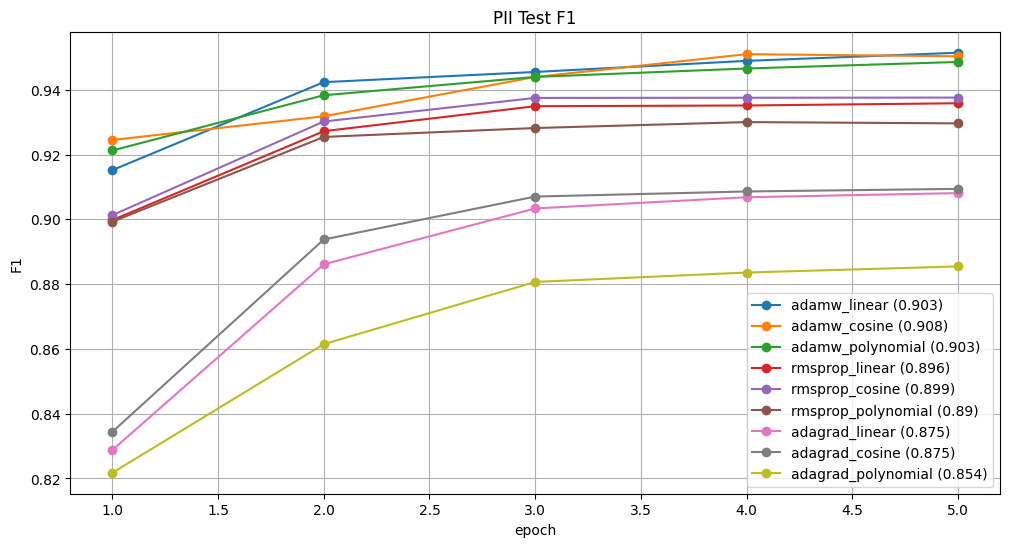

In [10]:
df = pd.read_pickle("data/pii.pkl")

plt.figure(figsize = (12,6))

for optim in df.index:
    for sched in df.columns:
        
        acc = glom(df.at[optim, sched]["log"], "*.eval_f1")
        
        plt.plot(np.arange(1,len(acc)+1),acc,"o-", label = f"{optim}_{sched} ({round(df.at[optim, sched]['overall_f1'],3)})")
    
        
plt.xlabel("epoch")
plt.ylabel("F1")
plt.title("PII Test F1")
plt.legend()
plt.grid()
plt.savefig("data/pii.png")
plt.show()

## Melanoma identification

In [2]:
skincancer_model_path = "apple/mobilevit-small"

skin_cancer = SkinCancer()
skin_cancer.load_image_processor(skincancer_model_path)
skin_cancer.prepare_dataset()

In [3]:
optimizers = {
    "adamw": (torch.optim.AdamW, {"lr": 1e-4}),
    "rmsprop": (torch.optim.RMSprop, {"lr": 3e-5, "momentum": 0}),
    "adagrad": (torch.optim.Adagrad, {"lr": 1e-4}),
}

schedulers = {
    "linear": {"num_warmup_steps": 0},
    "cosine": {"num_warmup_steps": 0},
    "polynomial": {"num_warmup_steps": 0, "power": 2}
}

In [7]:
df = skin_cancer.train(
    output_dir = "skin_cancer/",
    result_pickle = "data/skin_cancer.pkl",
    optimizers = optimizers,
    schedulers = schedulers,
    image_processor_path= skincancer_model_path,
    model_path = skincancer_model_path,
    epochs = 6,
    batch_size = 80,
    strategy="epoch",
    device = "cuda"
)

----------------------------
Optimizer: adamw | Scheduler: linear


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.9728994369506836, 'eval_accuracy': 0.7098715890850722, 'eval_runtime': 31.8481, 'eval_samples_per_second': 78.246, 'eval_steps_per_second': 1.005, 'epoch': 1.0}
{'eval_loss': 0.8441428542137146, 'eval_accuracy': 0.7203049759229535, 'eval_runtime': 32.779, 'eval_samples_per_second': 76.024, 'eval_steps_per_second': 0.976, 'epoch': 2.0}
{'eval_loss': 0.7600190043449402, 'eval_accuracy': 0.7471910112359551, 'eval_runtime': 31.9844, 'eval_samples_per_second': 77.913, 'eval_steps_per_second': 1.0, 'epoch': 3.0}
{'eval_loss': 0.7195119857788086, 'eval_accuracy': 0.7592295345104334, 'eval_runtime': 31.2763, 'eval_samples_per_second': 79.677, 'eval_steps_per_second': 1.023, 'epoch': 4.0}
{'loss': 0.9608, 'grad_norm': 4.68352746963501, 'learning_rate': 3.036211699164346e-05, 'epoch': 4.17}
{'eval_loss': 0.70466148853302, 'eval_accuracy': 0.7624398073836276, 'eval_runtime': 33.3098, 'eval_samples_per_second': 74.813, 'eval_steps_per_second': 0.961, 'epoch': 5.0}
{'eval_loss': 0.6

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.9604634046554565, 'eval_accuracy': 0.7102728731942215, 'eval_runtime': 33.0353, 'eval_samples_per_second': 75.434, 'eval_steps_per_second': 0.969, 'epoch': 1.0}
{'eval_loss': 0.8278851509094238, 'eval_accuracy': 0.7046548956661316, 'eval_runtime': 30.8338, 'eval_samples_per_second': 80.82, 'eval_steps_per_second': 1.038, 'epoch': 2.0}
{'eval_loss': 0.7431363463401794, 'eval_accuracy': 0.7435794542536116, 'eval_runtime': 33.0168, 'eval_samples_per_second': 75.477, 'eval_steps_per_second': 0.969, 'epoch': 3.0}
{'eval_loss': 0.7210772633552551, 'eval_accuracy': 0.7568218298555377, 'eval_runtime': 33.7845, 'eval_samples_per_second': 73.762, 'eval_steps_per_second': 0.947, 'epoch': 4.0}
{'loss': 0.9439, 'grad_norm': 4.207845211029053, 'learning_rate': 2.107280780856554e-05, 'epoch': 4.17}
{'eval_loss': 0.7030632495880127, 'eval_accuracy': 0.7604333868378812, 'eval_runtime': 32.9197, 'eval_samples_per_second': 75.699, 'eval_steps_per_second': 0.972, 'epoch': 5.0}
{'eval_loss'

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.0089235305786133, 'eval_accuracy': 0.7086677367576244, 'eval_runtime': 31.8301, 'eval_samples_per_second': 78.291, 'eval_steps_per_second': 1.005, 'epoch': 1.0}
{'eval_loss': 0.8602001070976257, 'eval_accuracy': 0.6970304975922953, 'eval_runtime': 33.3765, 'eval_samples_per_second': 74.663, 'eval_steps_per_second': 0.959, 'epoch': 2.0}
{'eval_loss': 0.8028802275657654, 'eval_accuracy': 0.7215088282504013, 'eval_runtime': 33.0531, 'eval_samples_per_second': 75.394, 'eval_steps_per_second': 0.968, 'epoch': 3.0}
{'eval_loss': 0.787138819694519, 'eval_accuracy': 0.7359550561797753, 'eval_runtime': 33.0221, 'eval_samples_per_second': 75.465, 'eval_steps_per_second': 0.969, 'epoch': 4.0}
{'loss': 0.9929, 'grad_norm': 2.102407932281494, 'learning_rate': 9.309362900660298e-06, 'epoch': 4.17}
{'eval_loss': 0.7841311693191528, 'eval_accuracy': 0.7291332263242376, 'eval_runtime': 32.3964, 'eval_samples_per_second': 76.922, 'eval_steps_per_second': 0.988, 'epoch': 5.0}
{'eval_loss'

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.2047979831695557, 'eval_accuracy': 0.7030497592295345, 'eval_runtime': 31.7993, 'eval_samples_per_second': 78.367, 'eval_steps_per_second': 1.006, 'epoch': 1.0}
{'eval_loss': 0.9766210913658142, 'eval_accuracy': 0.6978330658105939, 'eval_runtime': 31.9168, 'eval_samples_per_second': 78.078, 'eval_steps_per_second': 1.003, 'epoch': 2.0}
{'eval_loss': 0.9036579132080078, 'eval_accuracy': 0.7018459069020867, 'eval_runtime': 32.916, 'eval_samples_per_second': 75.708, 'eval_steps_per_second': 0.972, 'epoch': 3.0}
{'eval_loss': 0.8782216310501099, 'eval_accuracy': 0.7058587479935795, 'eval_runtime': 32.7775, 'eval_samples_per_second': 76.028, 'eval_steps_per_second': 0.976, 'epoch': 4.0}
{'loss': 1.1045, 'grad_norm': 2.2011215686798096, 'learning_rate': 9.108635097493037e-06, 'epoch': 4.17}
{'eval_loss': 0.8711571097373962, 'eval_accuracy': 0.7034510433386838, 'eval_runtime': 32.9014, 'eval_samples_per_second': 75.742, 'eval_steps_per_second': 0.973, 'epoch': 5.0}
{'eval_loss

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.170685887336731, 'eval_accuracy': 0.7046548956661316, 'eval_runtime': 31.999, 'eval_samples_per_second': 77.878, 'eval_steps_per_second': 1.0, 'epoch': 1.0}
{'eval_loss': 0.9515267014503479, 'eval_accuracy': 0.6970304975922953, 'eval_runtime': 32.1261, 'eval_samples_per_second': 77.569, 'eval_steps_per_second': 0.996, 'epoch': 2.0}
{'eval_loss': 0.8858720064163208, 'eval_accuracy': 0.7030497592295345, 'eval_runtime': 32.5692, 'eval_samples_per_second': 76.514, 'eval_steps_per_second': 0.983, 'epoch': 3.0}
{'eval_loss': 0.8671623468399048, 'eval_accuracy': 0.7082664526484751, 'eval_runtime': 32.929, 'eval_samples_per_second': 75.678, 'eval_steps_per_second': 0.972, 'epoch': 4.0}
{'loss': 1.0836, 'grad_norm': 2.3206493854522705, 'learning_rate': 6.3218423425696625e-06, 'epoch': 4.17}
{'eval_loss': 0.8665786385536194, 'eval_accuracy': 0.7038523274478331, 'eval_runtime': 33.2904, 'eval_samples_per_second': 74.856, 'eval_steps_per_second': 0.961, 'epoch': 5.0}
{'eval_loss': 

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.245488166809082, 'eval_accuracy': 0.702247191011236, 'eval_runtime': 32.8235, 'eval_samples_per_second': 75.921, 'eval_steps_per_second': 0.975, 'epoch': 1.0}
{'eval_loss': 1.0284228324890137, 'eval_accuracy': 0.6978330658105939, 'eval_runtime': 31.9063, 'eval_samples_per_second': 78.104, 'eval_steps_per_second': 1.003, 'epoch': 2.0}
{'eval_loss': 0.9583920240402222, 'eval_accuracy': 0.7014446227929374, 'eval_runtime': 32.7912, 'eval_samples_per_second': 75.996, 'eval_steps_per_second': 0.976, 'epoch': 3.0}
{'eval_loss': 0.9388627409934998, 'eval_accuracy': 0.7002407704654896, 'eval_runtime': 32.9254, 'eval_samples_per_second': 75.686, 'eval_steps_per_second': 0.972, 'epoch': 4.0}
{'loss': 1.1517, 'grad_norm': 1.7730259895324707, 'learning_rate': 2.8563558631605894e-06, 'epoch': 4.17}
{'eval_loss': 0.9353223443031311, 'eval_accuracy': 0.7014446227929374, 'eval_runtime': 30.4875, 'eval_samples_per_second': 81.739, 'eval_steps_per_second': 1.05, 'epoch': 5.0}
{'eval_loss'

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.796858549118042, 'eval_accuracy': 0.528892455858748, 'eval_runtime': 33.3982, 'eval_samples_per_second': 74.615, 'eval_steps_per_second': 0.958, 'epoch': 1.0}
{'eval_loss': 1.7050663232803345, 'eval_accuracy': 0.6284109149277689, 'eval_runtime': 33.9402, 'eval_samples_per_second': 73.423, 'eval_steps_per_second': 0.943, 'epoch': 2.0}
{'eval_loss': 1.6442755460739136, 'eval_accuracy': 0.6749598715890851, 'eval_runtime': 32.1104, 'eval_samples_per_second': 77.607, 'eval_steps_per_second': 0.997, 'epoch': 3.0}
{'eval_loss': 1.603855013847351, 'eval_accuracy': 0.6753611556982343, 'eval_runtime': 32.9077, 'eval_samples_per_second': 75.727, 'eval_steps_per_second': 0.972, 'epoch': 4.0}
{'loss': 1.7267, 'grad_norm': 1.9374816417694092, 'learning_rate': 3.036211699164346e-05, 'epoch': 4.17}
{'eval_loss': 1.575021743774414, 'eval_accuracy': 0.6942215088282504, 'eval_runtime': 33.0828, 'eval_samples_per_second': 75.326, 'eval_steps_per_second': 0.967, 'epoch': 5.0}
{'eval_loss': 

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.7856719493865967, 'eval_accuracy': 0.5473515248796148, 'eval_runtime': 33.1615, 'eval_samples_per_second': 75.147, 'eval_steps_per_second': 0.965, 'epoch': 1.0}
{'eval_loss': 1.6775760650634766, 'eval_accuracy': 0.6500802568218299, 'eval_runtime': 31.4266, 'eval_samples_per_second': 79.296, 'eval_steps_per_second': 1.018, 'epoch': 2.0}
{'eval_loss': 1.6091558933258057, 'eval_accuracy': 0.6837881219903692, 'eval_runtime': 31.7792, 'eval_samples_per_second': 78.416, 'eval_steps_per_second': 1.007, 'epoch': 3.0}
{'eval_loss': 1.5713701248168945, 'eval_accuracy': 0.6797752808988764, 'eval_runtime': 31.9811, 'eval_samples_per_second': 77.921, 'eval_steps_per_second': 1.001, 'epoch': 4.0}
{'loss': 1.7042, 'grad_norm': 1.8984230756759644, 'learning_rate': 2.107280780856554e-05, 'epoch': 4.17}
{'eval_loss': 1.5505343675613403, 'eval_accuracy': 0.6954253611556982, 'eval_runtime': 31.0777, 'eval_samples_per_second': 80.186, 'eval_steps_per_second': 1.03, 'epoch': 5.0}
{'eval_loss

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([7, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 1.8091036081314087, 'eval_accuracy': 0.5108346709470305, 'eval_runtime': 32.0698, 'eval_samples_per_second': 77.706, 'eval_steps_per_second': 0.998, 'epoch': 1.0}
{'eval_loss': 1.7443009614944458, 'eval_accuracy': 0.6003210272873194, 'eval_runtime': 33.2612, 'eval_samples_per_second': 74.922, 'eval_steps_per_second': 0.962, 'epoch': 2.0}
{'eval_loss': 1.710712194442749, 'eval_accuracy': 0.6388443017656501, 'eval_runtime': 32.7017, 'eval_samples_per_second': 76.204, 'eval_steps_per_second': 0.979, 'epoch': 3.0}
{'eval_loss': 1.6955358982086182, 'eval_accuracy': 0.6492776886035313, 'eval_runtime': 31.3082, 'eval_samples_per_second': 79.596, 'eval_steps_per_second': 1.022, 'epoch': 4.0}
{'loss': 1.7685, 'grad_norm': 1.9391586780548096, 'learning_rate': 9.309362900660298e-06, 'epoch': 4.17}
{'eval_loss': 1.6825964450836182, 'eval_accuracy': 0.6621187800963082, 'eval_runtime': 32.5773, 'eval_samples_per_second': 76.495, 'eval_steps_per_second': 0.982, 'epoch': 5.0}
{'eval_loss

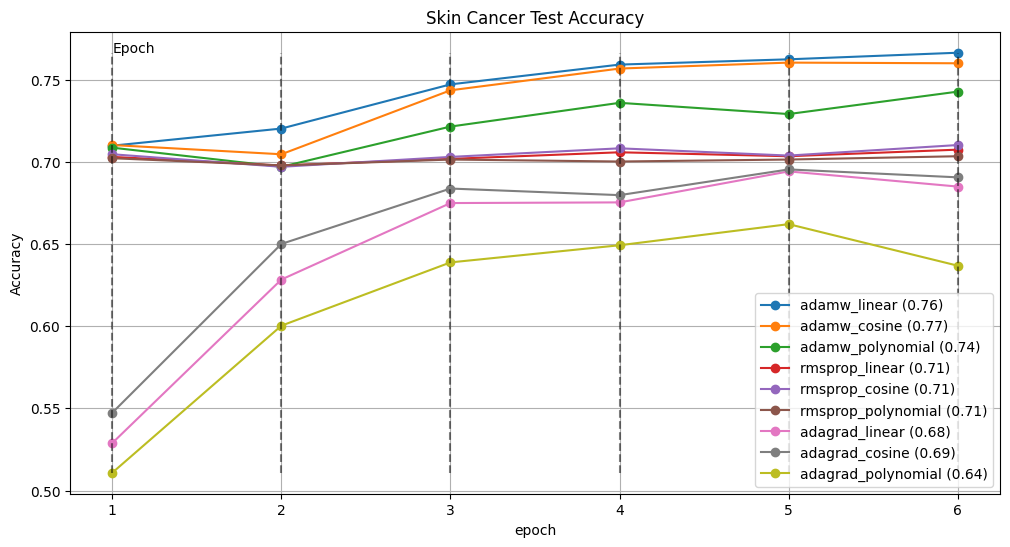

In [11]:
df = pd.read_pickle("data/skin_cancer.pkl")

plt.figure(figsize = (12,6))

for optim in df.index:
    for sched in df.columns:
        
        acc = glom(df.at[optim, sched]["log"], "*.eval_accuracy")
        
        plt.plot(np.arange(1,len(acc)+1),acc,"o-", label = f"{optim}_{sched} ({round(df.at[optim, sched]['accuracy'],3)})")
    
        
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title("Skin Cancer Test Accuracy")
plt.legend()
plt.grid()
plt.savefig("data/skin_cancer.png")
plt.show()

SGD Algorithms: 
- "adamw_torch"
- "adagrad"
- "rmsprop"


LR Schedulers:

- "cosine"
- "inverse_sqrt"

inverse_sqrt = lambda step: 1/math.sqrt(step, 100)

scheduler = LambdaLR(optimizer, lr_lambda = inverse_sqrt)


- "reduce_lr_on_plateau"